In [1]:
import networkit as nk
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import copy
import RITAP_core as rt

## Introduction

In this notebook we give an example of how to use RITAP to solve the integer traffic assignment problem (ITAP).


In this example we apply RITAP to the case of a random regular graph with origin-destination pairs picked uniformly at random (but with the constraint of the origin being distinct from the destination)

### Auxiliary functions
Stuff for plotting

In [2]:
#auxiliary functions to plot the network and the paths
def Plot_network(G): 
    to_plot_graph = nx.Graph()
    N=G.numberOfNodes()
    print(G.numberOfNodes())
    for i in range(N):
        to_plot_graph.add_node(i)
    for u,v in G.iterEdges():
        to_plot_graph.add_edge(u,v)

    weights = [(G.weight(u,v)) for u,v in G.iterEdges()]
    pos= nx.circular_layout(to_plot_graph)
    nx.draw(to_plot_graph,with_labels=True ,width = weights,pos=pos)
    plt.show()


def Plot_network_paths(G, paths): 
    N=G.numberOfNodes()
    G=copy.deepcopy(G) 
    for u,v in G.iterEdges():
        G.setWeight(u,v,1)
    for path in paths:
        for k in range(len(path)-1):
            G.setWeight(path[k],path[k+1],G.weight(path[k],path[k+1])+1)
    to_plot_graph = nx.Graph()
    for i in range(N):
        to_plot_graph.add_node(i)
    for u,v in G.iterEdges():
        to_plot_graph.add_edge(u,v,weight=(G.weight(u,v)))
        
    weights = np.log(np.array([(G.weight(u,v)) for u,v in G.iterEdges()])) #removing the logarithm will givethe whle graph, with thicker edges being those that get traversed the most.
    pos= nx.circular_layout(to_plot_graph)
    nx.draw(to_plot_graph,with_labels=True ,pos=pos,width=weights)
    plt.show()

## Graph generation
Generate the graph using the random regualr graph generator from networkx, then convert it into a networkit graph.

30


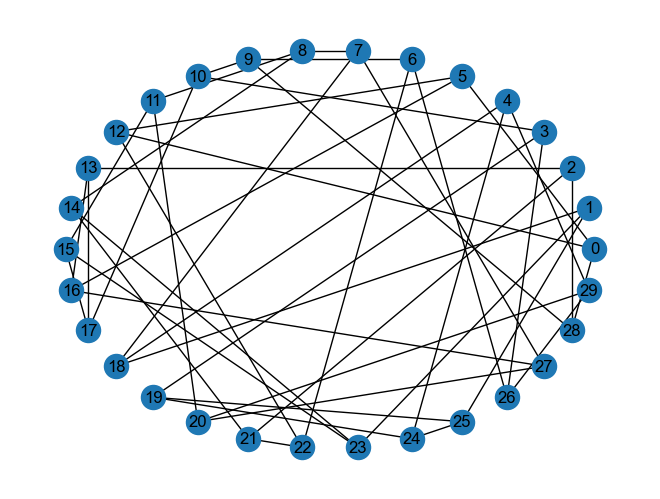

In [3]:
#generate random regular graph
N=30 #number of nodes
degree=3 #degree of each node
directed=False # directed or undirected graph (if directed the congestion can be different in the two directions of the edge)
nx_G=nx.random_regular_graph(d=degree, n=N,seed=1) #generate using networkx library

# To convert my networkx into networkit
G = nk.Graph(n=N, weighted=True, directed=directed)
for edge in nx_G.edges():
    G.addEdge(edge[0],edge[1]) 
    G.setWeight(edge[0],edge[1],1)
    if(G.isDirected()):
        G.addEdge(edge[1],edge[0])
        G.setWeight(edge[1],edge[0],1)

#plot the graph
if(N<=50 and degree<30):
    Plot_network(G)

## Generate origin destination pairs
A total of $M$ pairs is generated by picking each time two random distinct nodes in the graph

In [4]:
#generate random sources and destinations
M=60 #number of paths
start_nodes=[]
end_nodes=[]
for i in range(M):
    start_node,end_node=np.random.choice(N,2,replace=False)    
    start_nodes.append(start_node)
    end_nodes.append(end_node)


print("The sources are : ")
print(start_nodes)
print("The destinations are : ")
print(end_nodes)

#transform G into an undirected weighted graph
G = nk.graphtools.toWeighted(G)  #maybe check if weights on nodes

#------------------------------------------------------------------------------------------------------------------------------------ 
#cost function: when computing the total cost you will just use :phi(flow)
def phi(x,gamma):
    return x**(gamma)
def deriv_phi(x,gamma):
    return gamma*x**(gamma-1)

The sources are : 
[6, 26, 21, 23, 28, 17, 11, 4, 21, 27, 4, 3, 5, 6, 2, 11, 3, 8, 20, 6, 13, 7, 25, 26, 27, 20, 15, 10, 18, 22, 19, 16, 23, 21, 19, 25, 11, 19, 15, 7, 4, 17, 28, 3, 7, 13, 11, 20, 28, 29, 1, 1, 16, 26, 18, 16, 16, 18, 6, 21]
The destinations are : 
[9, 16, 1, 27, 13, 26, 16, 18, 6, 22, 14, 7, 2, 2, 4, 2, 9, 23, 29, 14, 4, 24, 5, 21, 21, 24, 14, 25, 14, 14, 22, 4, 17, 12, 13, 22, 10, 12, 16, 17, 0, 24, 19, 20, 5, 12, 18, 22, 7, 27, 0, 14, 20, 17, 10, 15, 24, 20, 10, 3]


# RITAP Routing


In [5]:
#converting into a bushes structure the start end pair
bushes=rt.starts_ends_to_origin_bush(start_nodes, end_nodes)

In [6]:
gamma=2#parameter of the cost function
tmax=1000 #maximum number of iterations
rtol=0#relative tolerance for the convergence of the algorithm
rel_opt_gap_thr=0 # when the energy is smaller than (1+rel_opt_gap_thr)* H_star, the algorithm stops. H_star is the optimal value of the energy
FLOW_EPS=1e-10 #threshold for the flow of a path to be considered as non-zero
lr = [1 / t ** (0.5+ 0.5 * t / tmax) for t in range(1, tmax+1)] #empirically this seems to be the best scaling, beating also the line search
if(G.isDirected()):
    (G_traf,G,dict_paths,energies,opt_gaps,flag_conv,final_t) = rt.FW_traffic_assignment_single_commodity_directed(bushes,G,lr,tmax,phi=lambda x: phi(x, gamma),deriv_phi=lambda x: deriv_phi(x, gamma),rtol=rtol,rel_opt_gap_thr=rel_opt_gap_thr)  # compute the flow of each commodity
else:
    (G_traf,G,dict_paths,energies,opt_gaps,flag_conv,final_t) = rt.FW_traffic_assignment_single_commodity(bushes,G,lr,tmax,phi=lambda x: phi(x, gamma),deriv_phi=lambda x: deriv_phi(x, gamma),rtol=rtol,rel_opt_gap_thr=rel_opt_gap_thr)  # compute the flow of each commodity


paths_dict = rt.flows_to_paths(G_traf, dict_paths, bushes, flow_eps=FLOW_EPS)  # compute continuous paths from flows (the flow of a single commuter can be split among several paths each carrying a fraction of the total flow)
integer_paths_dict=rt.continuous_to_max_traf_integer_paths(paths_dict, bushes)# compute integer paths from continuous paths. For each start-end pair, the algorithm puts all the traffic on the path that is carrying the most traffic. For example if a traffic of 1 is split among three paths in the following proportions :0.45,0.35,0.2, the algorithm will choose the first path (carrying 0.45) as integer path.


The paths and the respective flow carried by each of them are contained in the nested dictionary integer_paths_dict.
`integer_paths_dict[start][end]` contains all the information about the paths starting at 'start' and terminating in 'end'
More precisely `integer_paths_bush[start][end]=[[pi_1,...,pi_R],[tINT_1,...,tINT_R], [t_1,...,t_R]]` with `pi_i` are paths from start to end carrying an integer amount of flow `tINT_i` and originally carrying an amount of flow `t_i` in the continuous solution. One can disregard `t_i` if one is only interested in the integer solution.

The advantage of using this data structure in place of just listing the paths from one to $M$, is that the size of this representation stays constant when $M\gg N^2$, in fact the number of start, end pairs is a  most $N(N-1)$, moreover the length of each of the lists `[pi_1,...,pi_R],[tINT_1,...,tINT_R], [t_1,...,t_R]` is usually bounded even when $M$ is large.



In [7]:
#in this cell we plot the flow per edge ot the RITAP solution
G_traf_int=rt.copy_graph(G, reset_weights=True, weight_value=0) #create a new graph with the same structure as G, but with all weights set to 0
for start in integer_paths_dict:
   for end in integer_paths_dict[start]:
       for i,path in enumerate(integer_paths_dict[start][end][0]):
           for k in range(len(path)-1):
               G_traf_int.setWeight(path[k],path[k+1],G_traf_int.weight(path[k],path[k+1])+integer_paths_dict[start][end][1][i])


30


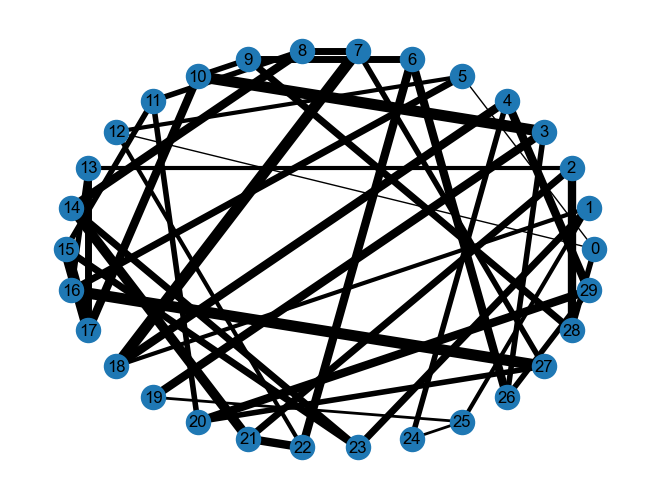

In [8]:
#plotting the flow (traffic) on the edges of the network
Plot_network(G_traf_int)
#the plotting might not work well in the directed case.